# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# install finrl library
# !git clone https://github.com/AI4Finance-LLC/FinRL-Library.git

fatal: destination path 'FinRL-Library' already exists and is not an empty directory.


In [2]:
import sys
sys.path.append("FinRL-Library")

In [3]:
# install packages
!pip install yfinance

In [4]:
!pip install stockstats

In [5]:
!pip install git+https://github.com/quantopian/pyfolio

  Cloning https://github.com/quantopian/pyfolio to /private/var/folders/yd/6f7x8029391303qq8xy315rr0000gn/T/pip-req-build-jqv7fgov
  Running command git clone -q https://github.com/quantopian/pyfolio /private/var/folders/yd/6f7x8029391303qq8xy315rr0000gn/T/pip-req-build-jqv7fgov


In [6]:
# ## install finrl library
#!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [9]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [10]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [11]:
print(config.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [12]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-07-06',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [13]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.778781,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,45.615864,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.579443,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,32.475803,7117200,CAT,4


In [14]:
df.tail()

,date,open,high,low,close,volume,tic,day
91836,2021-07-02,405.089996,409.869995,403.880005,406.601990,1982400,UNH,4
91837,2021-07-02,235.830002,238.779999,235.820007,237.886368,4383700,V,4
91838,2021-07-02,56.380001,56.570000,56.259998,54.501297,11387100,VZ,4
91839,2021-07-02,49.110001,49.139999,47.570000,47.243721,15863200,WBA,4
91840,2021-07-02,139.350006,141.080002,139.350006,139.036484,8760200,WMT,4


In [15]:
df.shape

(91841, 8)

In [16]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.778781,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,45.615864,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.579443,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,32.475803,7117200,CAT,4


In [17]:
len(df.tic.unique())

30

In [18]:
df.tic.value_counts()

AAPL    3147
AMGN    3147
WMT     3147
WBA     3147
VZ      3147
V       3147
UNH     3147
TRV     3147
PG      3147
NKE     3147
MSFT    3147
MRK     3147
MMM     3147
MCD     3147
KO      3147
JPM     3147
JNJ     3147
INTC    3147
IBM     3147
HON     3147
HD      3147
GS      3147
DIS     3147
CVX     3147
CSCO    3147
CRM     3147
CAT     3147
BA      3147
AXP     3147
DOW      578
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [19]:
tech_indicators = ['macd',
 'rsi_30',
 'cci_30',
 'dx_30']

In [20]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [21]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
41602,2014-09-15,41.450001,41.580002,41.330002,32.823273,12259600,KO,0,0.246063,55.594741,45.906093,11.643574,13.713126
64937,2017-11-22,36.700001,36.720001,36.360001,32.123077,17226400,CSCO,2,0.588789,68.351253,214.916235,53.420088,20.228125
8088,2010-02-10,27.001823,27.217539,26.776731,15.434521,16152658,VZ,2,-0.426658,39.377842,-105.354638,54.202399,3.503724
17577,2011-05-31,77.800003,78.349998,77.410004,63.016693,4706400,BA,1,0.290107,57.621937,24.339954,0.007341,15.568651
44512,2015-02-06,48.250000,49.759998,48.000000,36.024055,47425400,VZ,4,0.160496,57.586640,227.437327,28.225637,45.737379


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [22]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 175


In [23]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [24]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2009-01-01'
train_end = '2020-04-01'
val_test_start = '2020-04-01'
val_test_end = '2021-07-20'

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [25]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }


timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [26]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  200.93036022612276
======Model training from:  2009-01-01 to  2020-04-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_2
---------------------------------------
| time/                 |             |
|    fps                | 50          |
|    iterations         | 100         |
|    time_elapsed       | 9           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_variance | -0.183      |
|    learning_rate      | 0.0005      |
|    n_updates          | 99          |
|    policy_loss        | 3.58        |
|    reward             | -0.11795554 |
|    std                | 1           |
|    value_loss         | 0.299       |
---------------------------------------
------------------------------------
| time/                 |          |

-------------------------------------
| time/                 |           |
|    fps                | 128       |
|    iterations         | 1400      |
|    time_elapsed       | 54        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 1399      |
|    policy_loss        | 66.7      |
|    reward             | 1.6064793 |
|    std                | 1         |
|    value_loss         | 7.21      |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 130         |
|    iterations         | 1500        |
|    time_elapsed       | 57          |
|    total_timesteps    | 7500        |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.0005

======PPO Validation from:  2020-04-02 to  2020-07-02
PPO Sharpe Ratio:  0.23484240677799165
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_126_2
day: 2830, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3084377.71
total_reward: 2084377.71
total_cost: 2000.09
total_trades: 37018
Sharpe: 0.633
------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 82          |
|    time_elapsed    | 137         |
|    total_timesteps | 11324       |
| train/             |             |
|    actor_loss      | -118        |
|    critic_loss     | 307         |
|    learning_rate   | 5e-06       |
|    n_updates       | 8493        |
|    reward          | -10.6124935 |
------------------------------------
======DDPG Validation from:  2020-04-02 to  2020-07-02
======Best Model Retraining from:  2009-01-01 to  2020-07

--------------------------------------
| time/                 |            |
|    fps                | 141        |
|    iterations         | 1300       |
|    time_elapsed       | 45         |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | -0.264     |
|    learning_rate      | 0.0005     |
|    n_updates          | 1299       |
|    policy_loss        | 352        |
|    reward             | 0.15684502 |
|    std                | 1.01       |
|    value_loss         | 61.2       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 141        |
|    iterations         | 1400       |
|    time_elapsed       | 49         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0.172      |
|    learning_rate      |

-----------------------------------------
| time/                   |             |
|    fps                  | 146         |
|    iterations           | 5           |
|    time_elapsed         | 70          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.025883837 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.3       |
|    explained_variance   | -0.00466    |
|    learning_rate        | 0.00025     |
|    loss                 | 5.84        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0253     |
|    reward               | -1.1781743  |
|    std                  | 1.01        |
|    value_loss           | 18.7        |
-----------------------------------------
======PPO Validation from:  2020-07-02 to  2020-10-01
PPO Sharpe Ratio:  0.23612307134693242
======DDPG Training========
{'buffer_size': 100000, 'learning_rate'

---------------------------------------
| time/                 |             |
|    fps                | 138         |
|    iterations         | 1100        |
|    time_elapsed       | 39          |
|    total_timesteps    | 5500        |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | -1.64       |
|    learning_rate      | 0.0005      |
|    n_updates          | 1099        |
|    policy_loss        | 76.7        |
|    reward             | -0.06845463 |
|    std                | 1           |
|    value_loss         | 3.73        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 139        |
|    iterations         | 1200       |
|    time_elapsed       | 43         |
|    total_timesteps    | 6000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | -0.0824    |
|    lear

-----------------------------------------
| time/                   |             |
|    fps                  | 143         |
|    iterations           | 4           |
|    time_elapsed         | 56          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.021455348 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0317     |
|    learning_rate        | 0.00025     |
|    loss                 | 24.2        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.016      |
|    reward               | 2.8415692   |
|    std                  | 1           |
|    value_loss           | 35          |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 143       |
|    iterations           | 5         |


-------------------------------------
| time/                 |           |
|    fps                | 136       |
|    iterations         | 1000      |
|    time_elapsed       | 36        |
|    total_timesteps    | 5000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | -0.216    |
|    learning_rate      | 0.0005    |
|    n_updates          | 999       |
|    policy_loss        | -186      |
|    reward             | 0.6833876 |
|    std                | 1         |
|    value_loss         | 29.2      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 136       |
|    iterations         | 1100      |
|    time_elapsed       | 40        |
|    total_timesteps    | 5500      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | -0.00243  |
|    learning_rate      | 0.0005    |
|    n_updat

-----------------------------------------
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 3           |
|    time_elapsed         | 43          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.019610215 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.3       |
|    explained_variance   | 0.0105      |
|    learning_rate        | 0.00025     |
|    loss                 | 42.6        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0218     |
|    reward               | -0.12797974 |
|    std                  | 1           |
|    value_loss           | 66.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 139         |
|    iterations           | 4     

In [27]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2020-04-02,2020-07-02,PPO,0.182872,0.234842,0.131854
1,189,2020-07-02,2020-10-01,DDPG,0.221244,0.236123,0.357799
2,252,2020-10-01,2020-12-31,DDPG,0.143104,0.239724,0.352803
3,315,2020-12-31,2021-04-05,DDPG,0.300845,0.347471,0.444284


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [28]:
unique_trade_date = processed[(processed.date > val_test_start)&(processed.date <= val_test_end)].date.unique()

In [29]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  1.9637070047368312


In [30]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2020-07-02,NaN,2020-07-02
1,1.002469e+06,2020-07-06,0.002469,2020-07-06
2,9.991857e+05,2020-07-07,-0.003275,2020-07-07
3,1.001200e+06,2020-07-08,0.002016,2020-07-08
4,9.966372e+05,2020-07-09,-0.004557,2020-07-09


<AxesSubplot:>

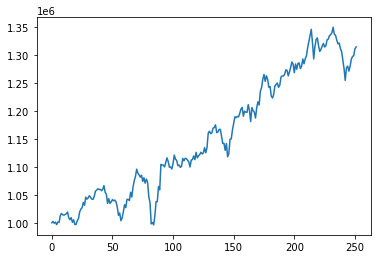

In [31]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [32]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.314927
Cumulative returns     0.314927
Annual volatility      0.145405
Sharpe ratio           1.963707
Calmar ratio           3.459039
Stability              0.940512
Max drawdown          -0.091045
Omega ratio            1.390125
Sortino ratio          3.082943
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.208719
Daily value at risk   -0.017186
dtype: float64


In [33]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.337432
Cumulative returns     0.335890
Annual volatility      0.146098
Sharpe ratio           2.072078
Calmar ratio           3.778308
Stability              0.944970
Max drawdown          -0.089308
Omega ratio            1.411593
Sortino ratio          3.102218
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.078766
Daily value at risk   -0.017205
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Start date,2020-07-02
End date,2021-07-01
Total months,12
,Backtest
Annual return,31.493%
Cumulative returns,31.493%
Annual volatility,14.541%
Sharpe ratio,1.96
Calmar ratio,3.46
Stability,0.94
Max drawdown,-9.104%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.10,2020-10-12,2020-10-30,2020-11-09,21
1,7.05,2021-06-04,2021-06-18,NaT,NaN
2,5.89,2020-09-02,2020-09-23,2020-10-08,27
3,4.87,2021-01-14,2021-01-29,2021-02-05,17
4,3.95,2021-05-10,2021-05-12,2021-06-04,20


Stress Events,mean,min,max
New Normal,0.11%,-3.66%,4.31%


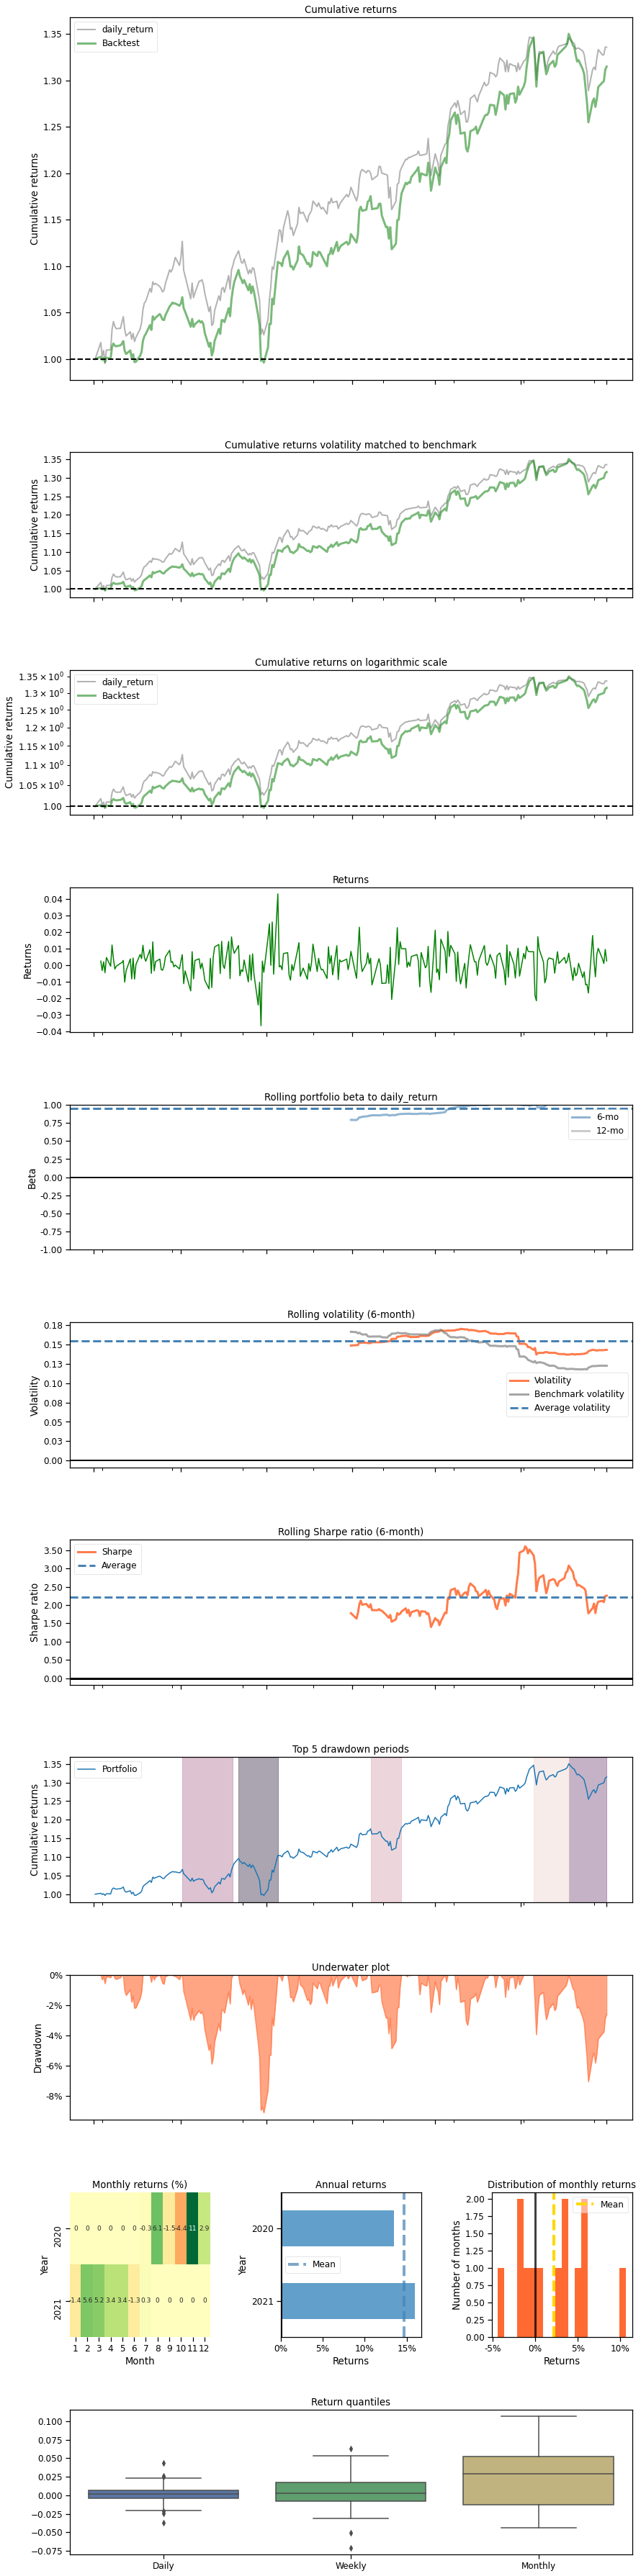

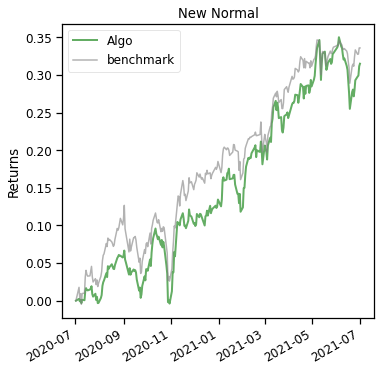

In [34]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])